<a href="https://colab.research.google.com/github/ShaoFuLiu/tSDRG_DataAnalysis/blob/master/TestSortingData_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **tSDRG Data Analysis**

### 1. **Before start plotting, please change the file path "my_metadata_file = ..." to your own metadata directory.**
### &emsp;*By defalt is for dropbox path.*
### 2. **Dim / Jdis = Dimerization / Randomness strength** 

### 3. **DimABC / JdisABC = Dimerization A.BC / Randomness strength A.BC**
### &emsp;*example: Dim123 = Dimerization 1.23*

# **Define metadata directory path**

In [1]:
## ------------------------------------------ Please change blow path to your own metadata directory path ------------------------------------------
# my_metadata_file = '../tSDRG_metadata/Spin1/metadata/' ## Your local path (not necessary)
my_metadata_file = '/mnt/c/Users/LiuSF/Dropbox/Proj_tSDRG/figs/Data and Plot python file/Spin1_metadata/Spin1/metadata/'
# my_metadata_file = './Spin2_metadata/' ## Defalt

# **Import lib and set basic parameter**

In [2]:
## Import library
import os
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkorange':           '#FF8C00',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', '^-', 'x-', 's-', 'p-', '*-', 'h-']   ## marker array
marr_nl = ['o', '^', 'x', 's', 'p', '*', 'h']       ## marker array (no line)

spin = int(1)                                       ## Spin type
BC = 'PBC'                                          ## Boundary condition
P = 10                                              ## Random distribution type (10 == Exponential distribution)
M = 30                                              ## Bound dimension 
font_size = 30

ALL_Dimer = ["Dim000"]
ALL_Jdis = ["Jdis000"]

Ddiff = 1
init_D = 0      ## Dim000 = 0.00
final_D = 100   ## Dim100 = 1.00
ds = (final_D - init_D)/Ddiff-1
for i in range (int(ds)+1):
    strD = "Dim00" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 10):
        strD = "Dim0" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 100):
        strD = "Dim" + str((i+1)*Ddiff+init_D) 
    ALL_Dimer.append(strD)

Jdiff = 1
init_J = 0      ## Jdis000 = 0.00
final_J = 200   ## Jdis200 = 2.00
js = (final_J - init_J)/Jdiff-1
for i in range (int(js)+1):
    strJ = "Jdis00" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 10):
        strJ = "Jdis0" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 100):
        strJ = "Jdis" + str((i+1)*Jdiff+init_J)
    ALL_Jdis.append(strJ)
# print(ALL_Dimer) ## ALL_Dimer = [Dim000, Dim001, ... , Dim099, Dim100]
# print(ALL_Jdis)  ## ALL_Jdis = [Jdis000, Jdis001, ... , Jdis599, Jdis200]

# **Define function**

In [4]:
def find_id(f_diff, skip_L): ## find crossing point index
    ids = []
    for id in range(len(f_diff)-1):
        if (np.sign(f_diff['diff'][id]) != np.sign(f_diff['diff'][id+1])):
            ids.append(id)

    if (len(ids) != 1):
        skip_L = True
        # if (len(ids) == 0):
        #     print("no crossing point")
        # else:
        #     print("too many crossing point")
    return ids, skip_L

def fitting_point(f_L1, f_L2, ids, var, para, n_point):
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
        x = (b2-b1)/(a1-a2)
    return x

def fitting_point_second(f_L1, f_L2, ids, var, para, L_n_point, R_n_point): ## use second-degree polynomial to fit curve
    for id in ids:   
        id_range = range(id-L_n_point, id+R_n_point) ## use R_n_point - L_n_point to fit

        a1, b1, c1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 2)
        a2, b2, c2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 2)
        a = a1-a2 
        b = b1-b2
        c = c1-c2
        x1 = (-b + (b**2 - 4*a*c)**0.5)/(2*a)
        x2 = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    return x1, x2
    
def fitting_point_slope(f_L1, f_L2, ids, var, para, n_point): ## return L1, L2 slope
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
    return a1, a2

def find_id_2(f_L, skip_L): ## find the index that sign changed
    ids = []
    for id in range(len(f_L)-1):
        if (np.sign(f_L['ZL'][id]) != np.sign(f_L['ZL'][id+1])):
            ids.append(id)

    if (len(ids) != 1):
        skip_L = True
        # if (len(ids) == 0):
        #     print("no crossing point")
        # else:
        #     print("too many crossing point")
    return ids, skip_L

def fitting_point_2(f_L, ids, var, para, n_point):
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a, b = np.polyfit(f_L[var][id_range], f_L[para][id_range], 1)
        x = -b/a
    return x

# **Plot**

## Fix **<font color = green>D</font>**, look **<font color = red>L</font>**, **ZL** vs **<font color = yellow>J</font>**

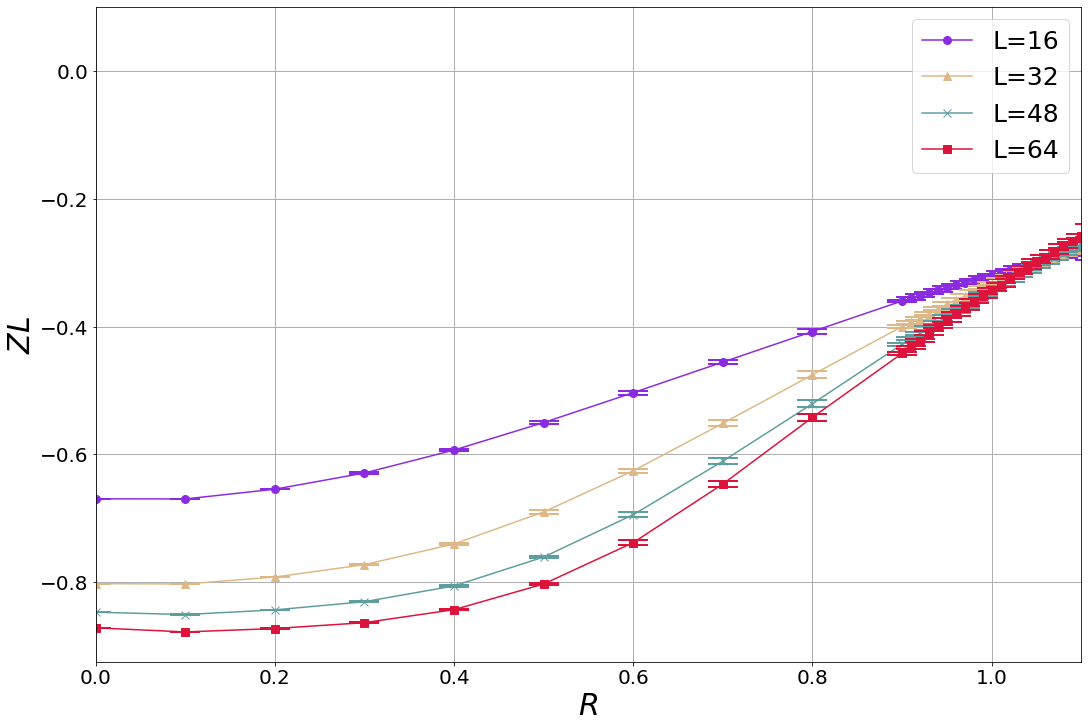

In [24]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                                    ## Choose SOP or ZL
# Ls = [16,24,32,40,48,56,64]                       ## Choose size
Ls = [16,32,48,64]     
Dimer = ["Dim000"]
Jdis = ALL_Jdis

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))

Para = "ZL"
ylable = r'$ZL$'

for l in range(len(Ls)):
    L = Ls[l]

    for d in range(len(Dimer)):        
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])    

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        ax.plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 8, label = 'L=%d' %(L))
        ax.errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
        ax.set_xlabel(r'$R$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        # ax.set_title("D = %.2f" %(D), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        ax.set_xlim([0, 1.1])
        # ax.set_ylim([-0.45, -0.25])
        ax.legend(loc = 'best',fontsize=25)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
plt.savefig('../tSDRG_figure/'+ OrderPara +'/Spin'+ str(spin) +'/Spin'+ str(spin) +'_'+ OrderPara +'_R-'+ dimer +'.pdf', format='pdf')
plt.show() 

## Fix **<font color = green>D</font>**, look **<font color = red>L</font>**, **ZL** vs **<font color = yellow>J</font>**, Multiplot

### **<font color = green>D</font>** = 0 ~ 0.20

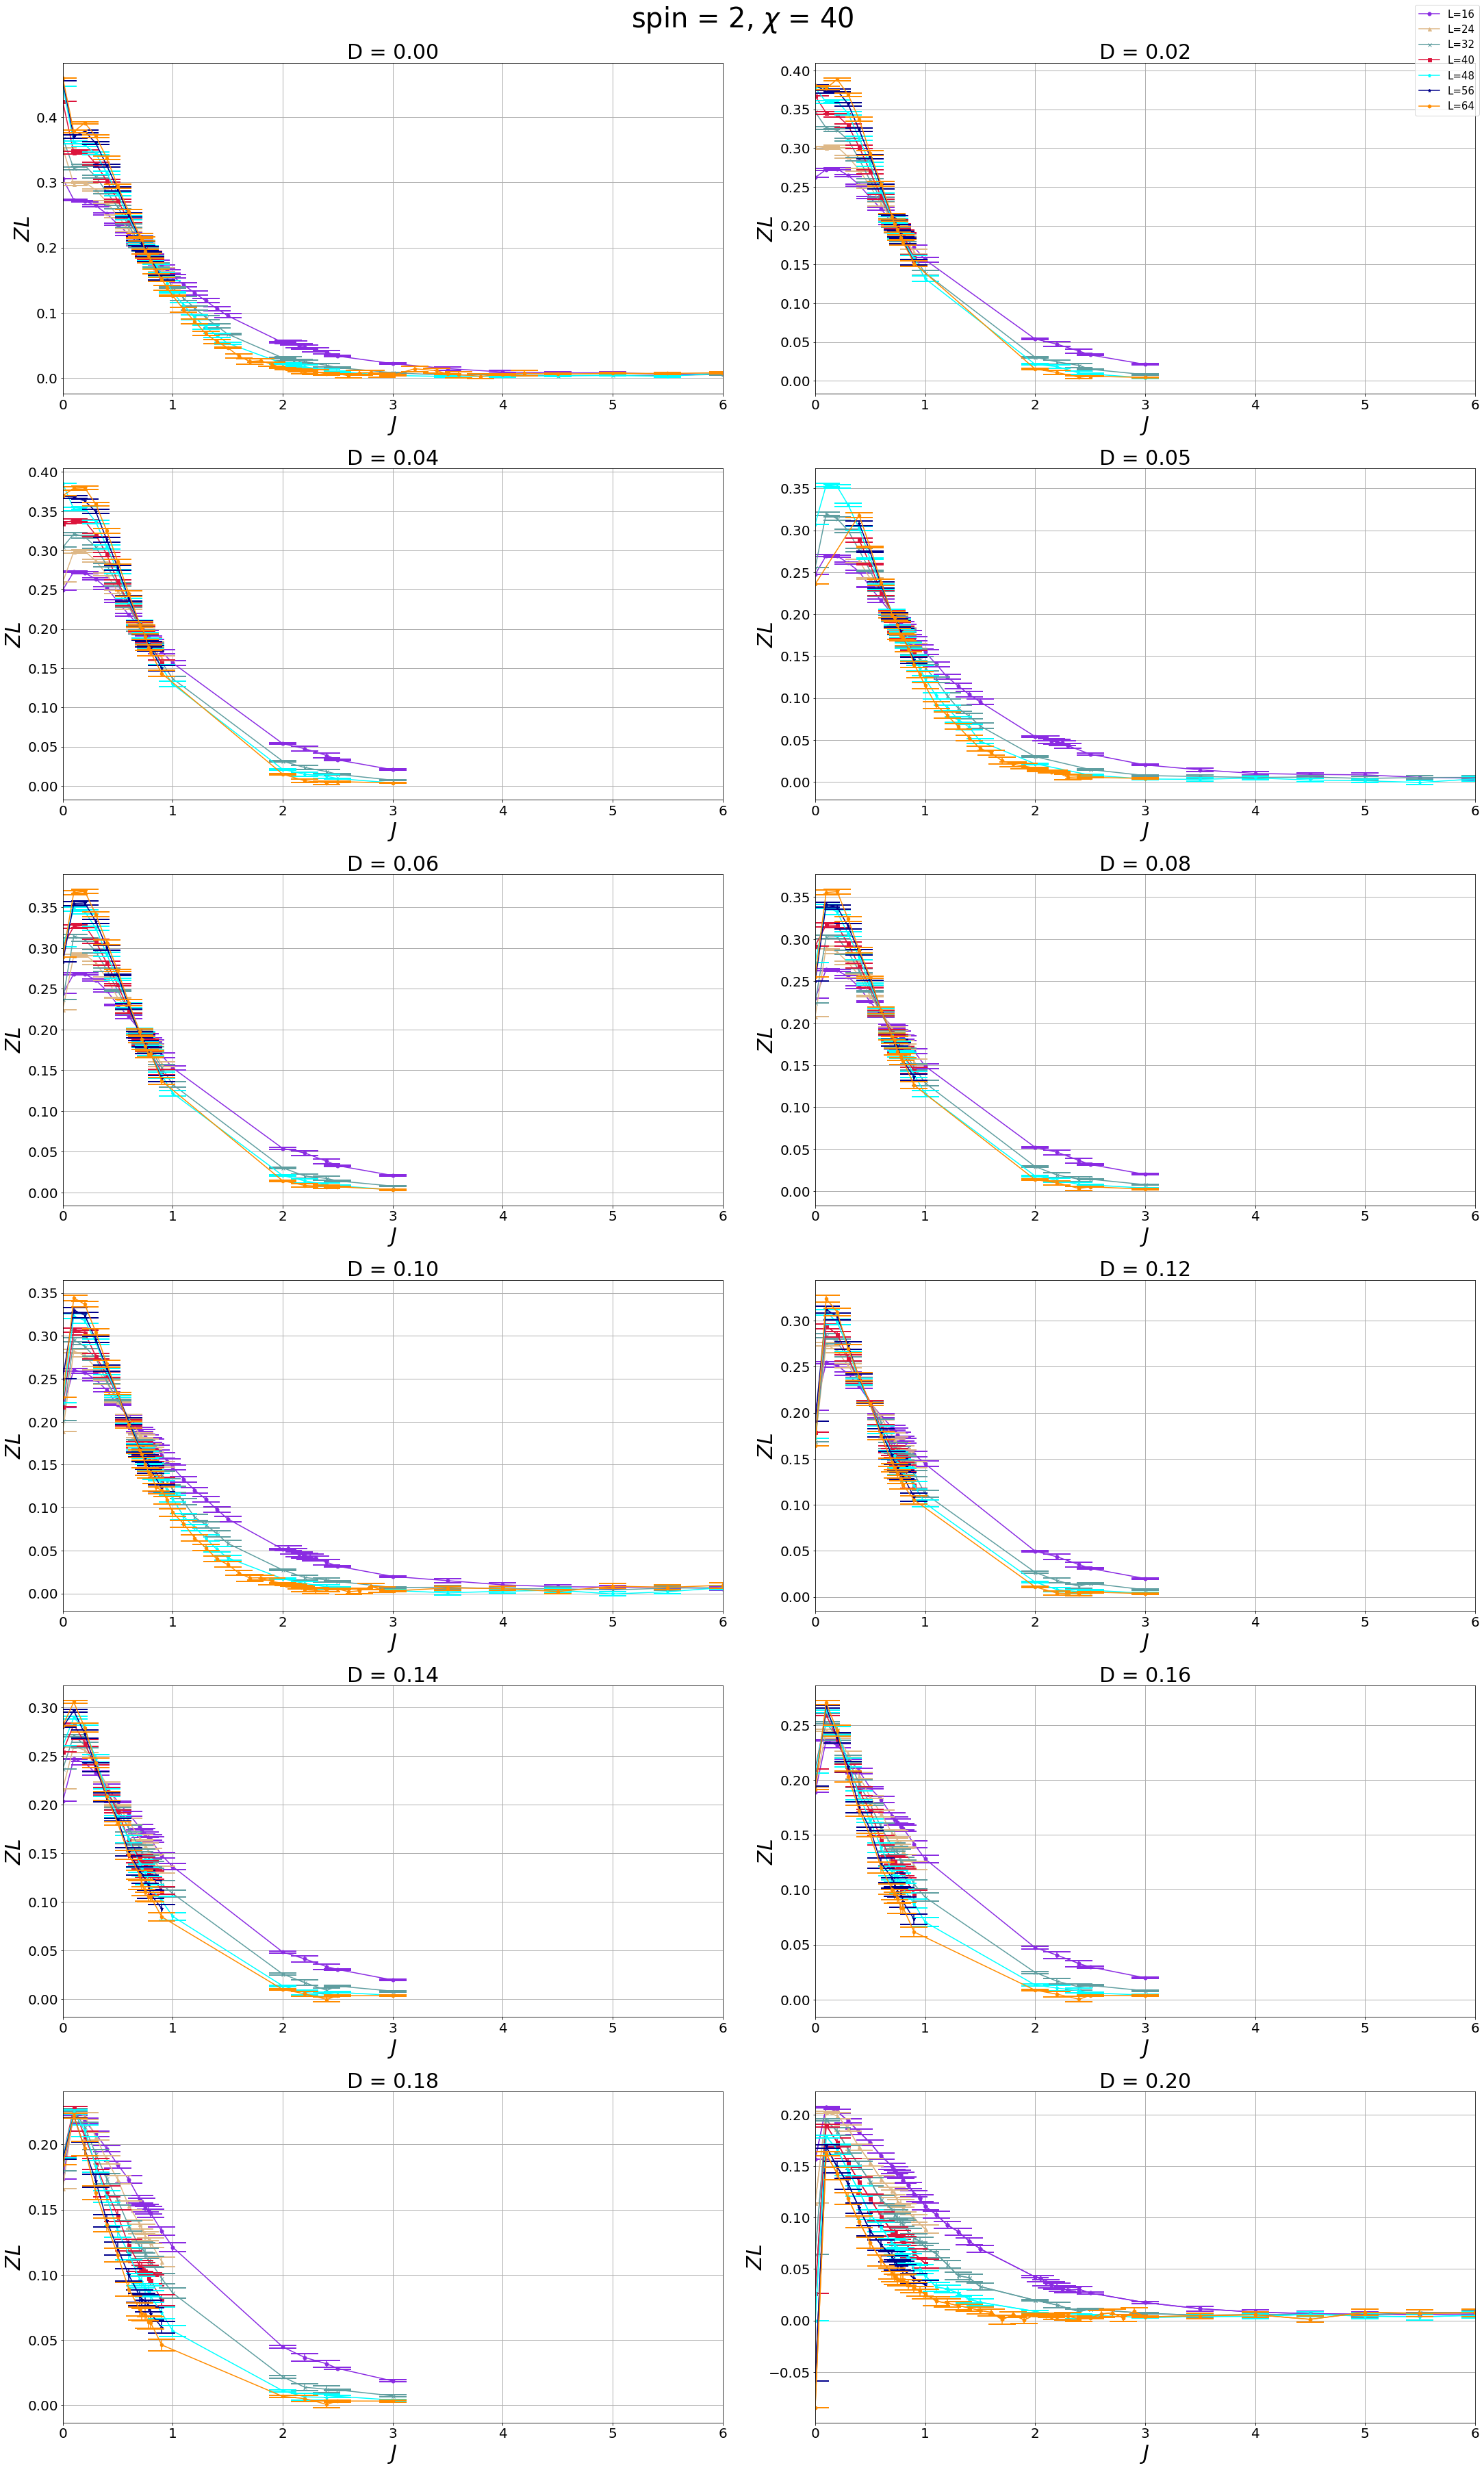

In [13]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64]
Dimer = ["Dim000","Dim002","Dim004","Dim005","Dim006","Dim008","Dim010","Dim012","Dim014","Dim016","Dim018","Dim020"]
Jdis = ALL_Jdis

# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(6, 2, constrained_layout=True, figsize=(30,50))

Para = "ZL"
ylable = r'$ZL$'

for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 6])                         ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

### **<font color = green>D</font>** = 0.25 ~ 0.54

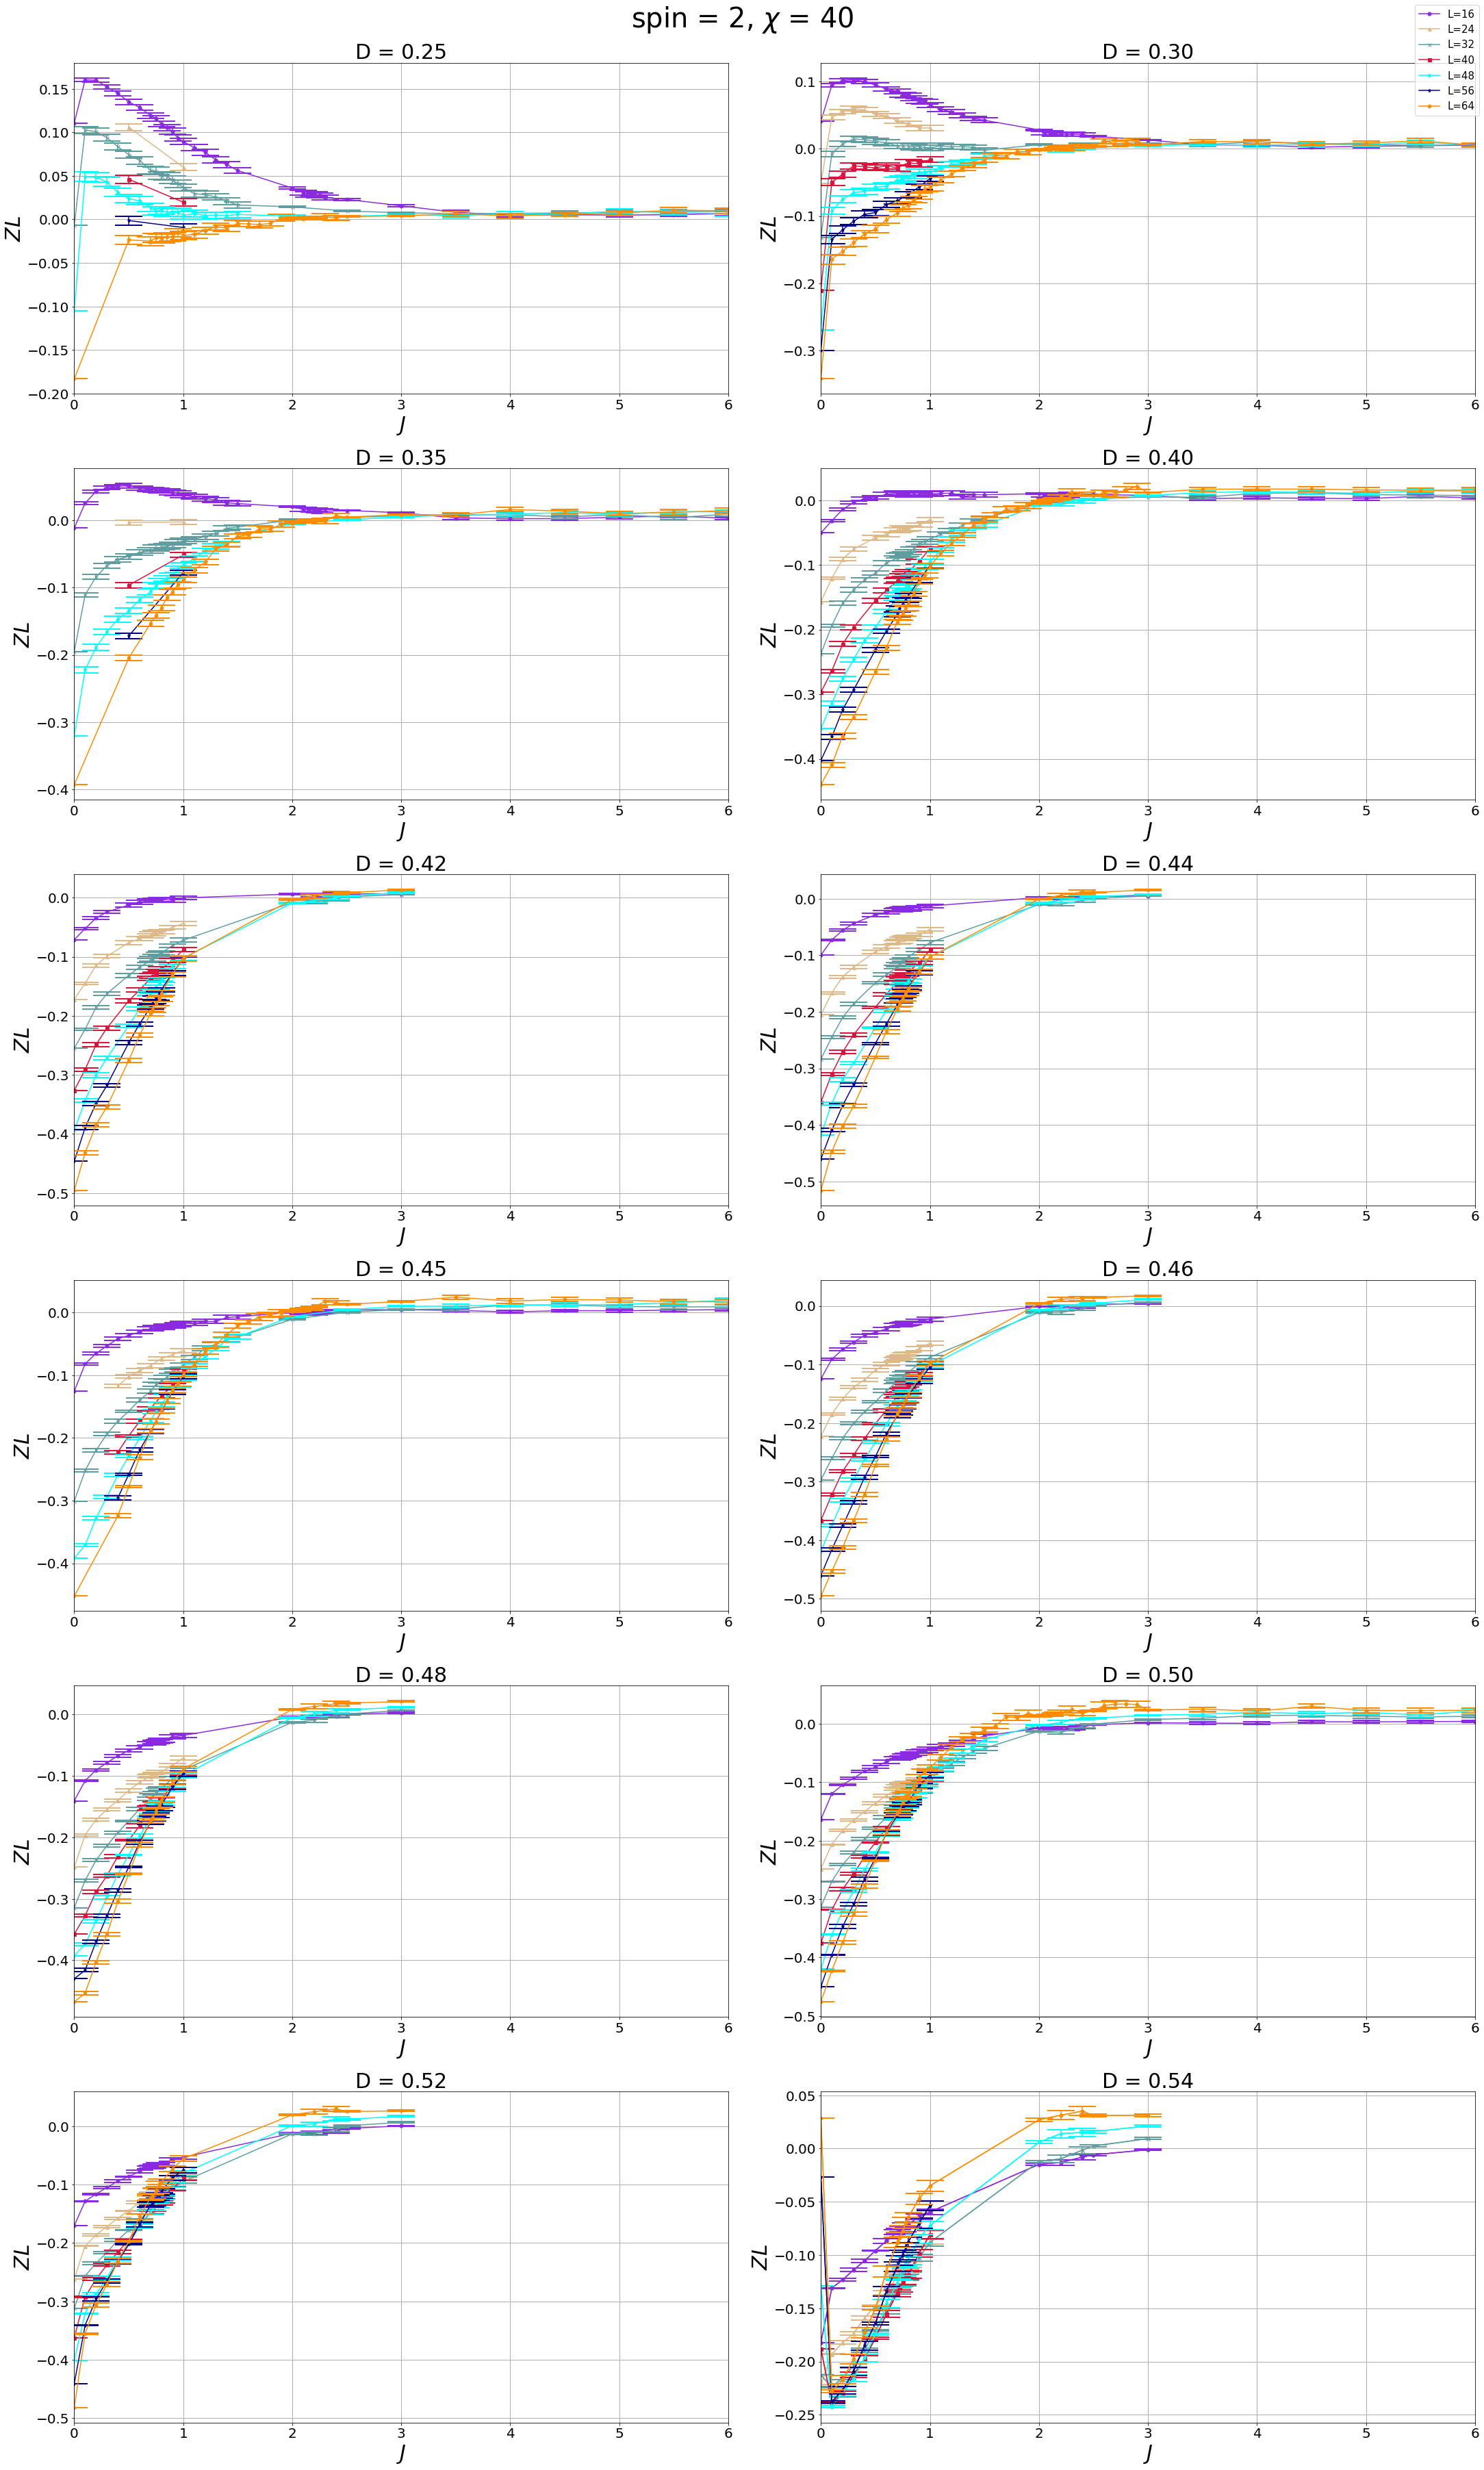

In [8]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64]
Dimer = ["Dim025","Dim030","Dim035","Dim040","Dim042","Dim044","Dim045","Dim046","Dim048","Dim050","Dim052","Dim054"]
Jdis = ALL_Jdis

# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(6, 2, constrained_layout=True, figsize=(30,50))

Para = "ZL"
ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 6])                       ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

### **<font color = green>D</font>** = 0.55 ~ 0.70

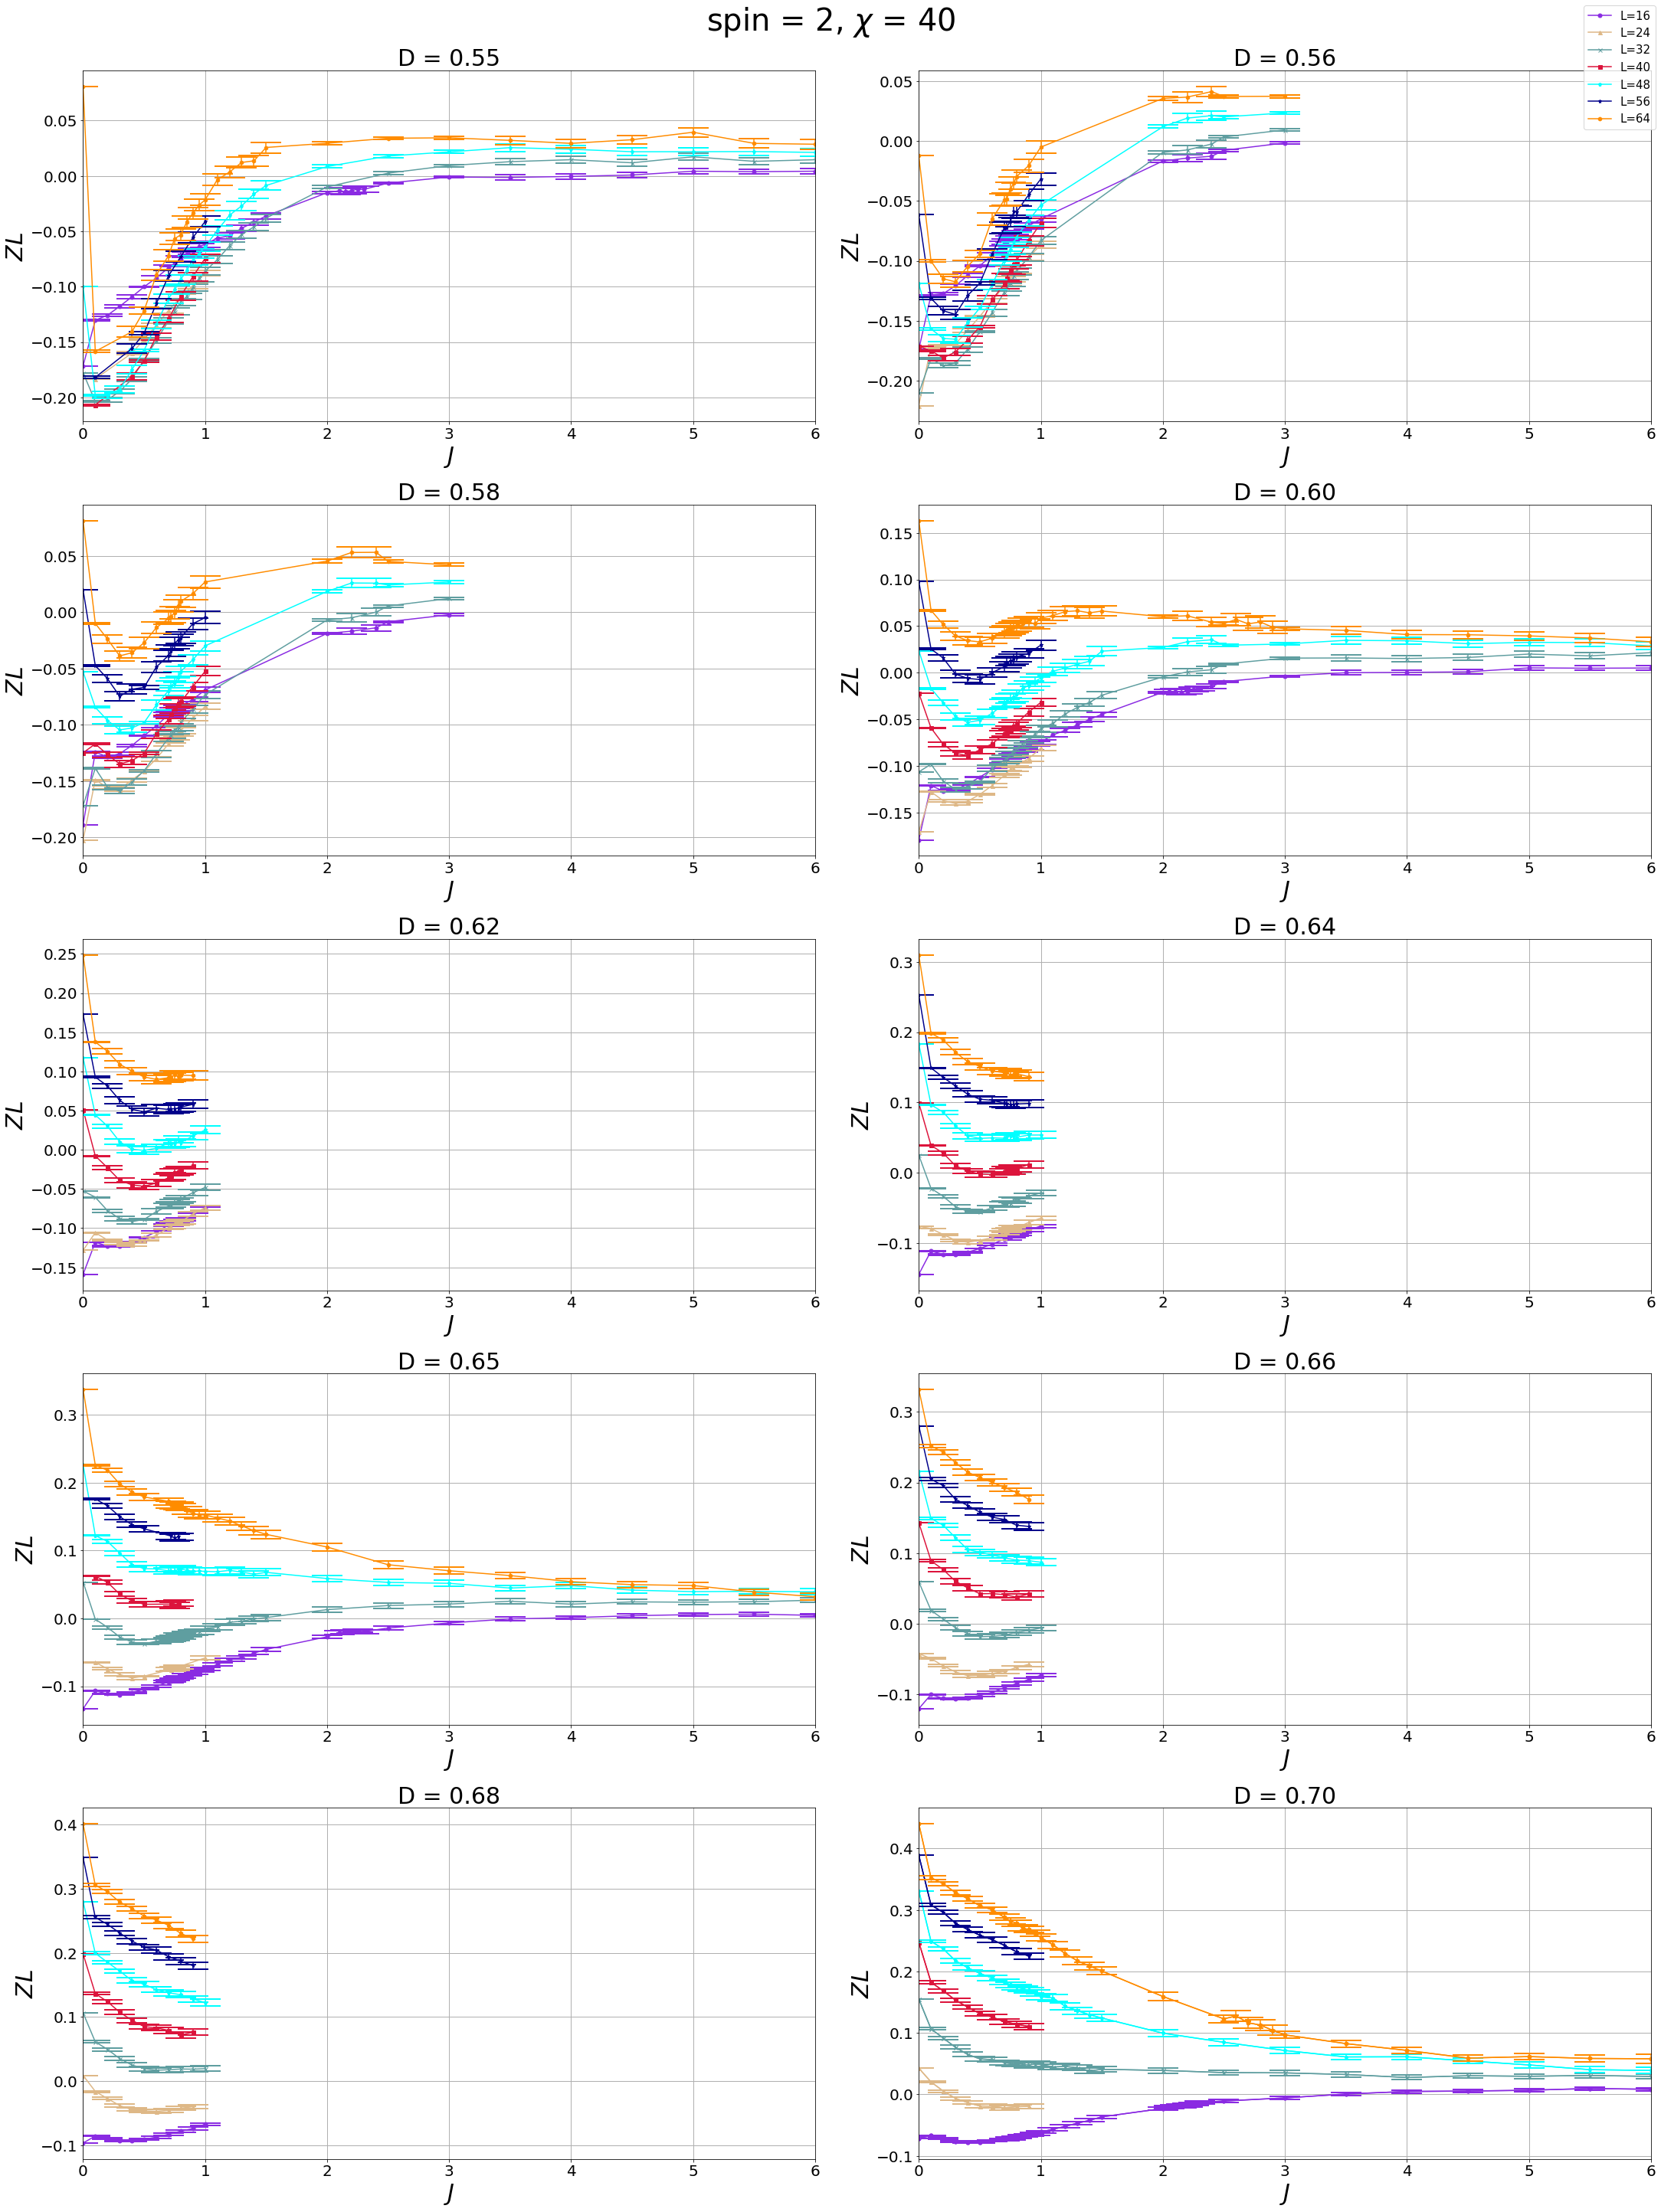

In [9]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64]
Dimer = ["Dim055","Dim056","Dim058","Dim060","Dim062","Dim064","Dim065","Dim066","Dim068","Dim070"]
Jdis = ALL_Jdis

# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,40))

Para = "ZL"
ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 6])                         ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

## 線性 fitting $J_c$(L_diff=0) vs 1/**<font color = red>L</font>**

In [18]:
PhaseDiagram_J1 = pd.DataFrame(columns = ['D', 'J1'])
PhaseDiagram_J2 = pd.DataFrame(columns = ['D', 'J2'])

In [30]:
## First crossing point J1
power = 1
OrderPara = "ZL"
Para = "ZL"

Ls = [16,24,32,40,48,56,64]
Dimer = ["Dim000","Dim001"]
Jdis = ALL_Jdis[72:83]
n_point = 4

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
    J1s = []
    x = []

    for l in range(len(Ls)-1):
        skip_L = False
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Jdis', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Jdis', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Jdis', 'diff'])
        ignore_num = 0
        # print(L1)

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
        
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
        
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            mean_L1 = {'Jdis':J, 'ZL':df_L1[Para][0]}
            mean_L2 = {'Jdis':J, 'ZL':df_L2[Para][0]}
            mean_diff = {'Jdis':J, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[j-ignore_num] = mean_L1
            f_L2.loc[j-ignore_num] = mean_L2
            f_diff.loc[j-ignore_num] = mean_diff

        ids, skip_L = find_id(f_diff, skip_L)
        # print(ids)
        if (skip_L):
            continue

        J1 = fitting_point(f_L1, f_L2, ids, "Jdis", Para, n_point)
        J1s.append(J1)
        x.append(L1**-1)

    x.append(0)
    p = np.polyfit(x[:-1], J1s, power)
    f = np.polyval(p,x)

    print('D = %.2f, L -> oo, J* = %.4f' %(D, p[power]))
    plt.plot(x[:-1], J1s, 'o-', markersize = font_size/3, color = carr[d], linewidth = font_size/15, label = 'D = %.2f, $J1_c$ = %.4f' %(D, p[power]))
    plt.plot(x, f, '--', markersize = font_size/3, color = carr[d], linewidth = font_size/15)

    mean_J = {'D':D, 'J1':p[power]}
    PhaseDiagram_J1.loc[d] = mean_J

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$J_1^*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
# plt.xlim(0, 0.07)
# plt.ylim(0, 0.2)
plt.grid(linestyle='-', linewidth=1)
plt.title('linear fit, first point J1, spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

TypeError: expected non-empty vector for x

In [ ]:
## First crossing point J2 ??
power = 1
OrderPara = "ZL"
Para = "ZL"

Ls = [16,24,32,40,48,56,64]
Dimer = ["Dim000","Dim001"]
Jdis = ALL_Jdis[72:83] ## ??
n_point = 4

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
    J1s = []
    x = []

    for l in range(len(Ls)-1):
        skip_L = False
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Jdis', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Jdis', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Jdis', 'diff'])
        ignore_num = 0
        # print(L1)

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
        
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
        
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            mean_L1 = {'Jdis':J, 'ZL':df_L1[Para][0]}
            mean_L2 = {'Jdis':J, 'ZL':df_L2[Para][0]}
            mean_diff = {'Jdis':J, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[j-ignore_num] = mean_L1
            f_L2.loc[j-ignore_num] = mean_L2
            f_diff.loc[j-ignore_num] = mean_diff

        ids, skip_L = find_id(f_diff, skip_L)
        # print(ids)
        if (skip_L):
            continue

        J1 = fitting_point(f_L1, f_L2, ids, "Jdis", Para, n_point)
        J1s.append(J1)
        x.append(L1**-1)

    x.append(0)
    p = np.polyfit(x[:-1], J1s, power)
    f = np.polyval(p,x)

    print('D = %.2f, L -> oo, J* = %.4f' %(D, p[power]))
    plt.plot(x[:-1], J1s, 'o-', markersize = font_size/3, color = carr[d+n], linewidth = font_size/15, label = 'D = %.2f, $J1_c$ = %.4f' %(D, p[power]))
    plt.plot(x, f, '--', markersize = font_size/3, color = carr[d+n], linewidth = font_size/15)

    mean_J = {'D':D, 'J1':p[power]}
    PhaseDiagram_J2.loc[d] = mean_J

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$J_1^*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
# plt.xlim(0, 0.07)
plt.ylim(0, 0.2)
plt.grid(linestyle='-', linewidth=1)
plt.title('linear fit, first point J1, spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

## Phase Diagram

In [ ]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,15))
## linear fit
ax[0].plot(PhaseDiagram_J1['D'], PhaseDiagram_J1['J1'], '-o', color="red", markersize = font_size/3)
ax[0].plot(PhaseDiagram_J2['D'], PhaseDiagram_J2['J2'], '-o', color="red", markersize = font_size/3)
ax[0].set_xlabel(r'$D$', fontsize=30)
ax[0].set_ylabel(r'$J$', fontsize=30)
ax[0].tick_params(axis='x', labelsize=20) 
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('Linear fit', fontsize=30)
ax[0].grid(linestyle='-', linewidth=1)
# ax[0].set_xlim([0, 0.6])                  
# ax[0].set_ylim([0, 2.6])          
# ax[0].legend(loc = 'best',fontsize=font_size*5/6)

## 2nd polynomial fit
# ax[1].plot(PhaseDiagram_D1_2['D'], PhaseDiagram_D1_2['J1'], '-o', color="red", markersize = font_size/3)
# ax[1].plot(PhaseDiagram_D2_2['D'], PhaseDiagram_D2_2['J2'], '-o', color="red", markersize = font_size/3)
# ax[1].set_xlabel(r'$D$', fontsize=30)
# ax[1].set_ylabel(r'$J$', fontsize=30)
# ax[1].tick_params(axis='x', labelsize=20) 
# ax[1].tick_params(axis='y', labelsize=20)
# ax[1].set_title('2nd polynomial fit', fontsize=30)
# ax[1].grid(linestyle='-', linewidth=1)
# ax[1].set_xlim([0, 0.6])                  
# ax[1].set_ylim([0, 2.6])          
# ax[1].legend(loc = 'best',fontsize=font_size*5/6)

## nonlinear fit
# ax[2].plot(PhaseDiagram_D1_nu['D'], PhaseDiagram_D1_nu['J1'], '-o', color="red", markersize = font_size/3)
# ax[2].plot(PhaseDiagram_D2_nu['D'], PhaseDiagram_D2_nu['J2'], '-o', color="red", markersize = font_size/3)
# ax[2].set_xlabel(r'$D$', fontsize=30)
# ax[2].set_ylabel(r'$J$', fontsize=30)
# ax[2].tick_params(axis='x', labelsize=20) 
# ax[2].tick_params(axis='y', labelsize=20)
# ax[2].set_title('Nonlinear fit', fontsize=30)
# ax[2].grid(linestyle='-', linewidth=1)
# ax[2].set_xlim([0, 0.6])                   
# ax[2].set_ylim([0, 2.6])          
# # ax[2].legend(loc = 'best',fontsize=font_size*5/6)

## ZL=0 fit
# ax[3].plot(PhaseDiagram_D1_zl['D'], PhaseDiagram_D1_zl['J1'], '-o', color="red", markersize = font_size/3)
# ax[3].plot(PhaseDiagram_D2_zl['D'], PhaseDiagram_D2_zl['J2'], '-o', color="red", markersize = font_size/3)
# ax[3].set_xlabel(r'$D$', fontsize=30)
# ax[3].set_ylabel(r'$J$', fontsize=30)
# ax[3].tick_params(axis='x', labelsize=20) 
# ax[3].tick_params(axis='y', labelsize=20)
# ax[3].set_title('ZL=0', fontsize=30)
# ax[3].grid(linestyle='-', linewidth=1)
# ax[3].set_xlim([0, 0.6])                  
# ax[3].set_ylim([0, 2.6])          
# # ax[3].legend(loc = 'best',fontsize=font_size*5/6)

fig.suptitle('Spin-2 Phase Diagram (直切)', fontsize=40)